# Clase Práctica 1

# Neural Network - LSTM

# Predicción de señales temporales

En este clase práctica, vamos a aplicar una red LSTM para predecir diferentes valores de una señal temporal. 

# Librerías

Se deben incluir las librerías para redes neuronales recurrentes, en este caso LSTM. 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten

# Importando los datos

Se uiliza pandas para leer los datos en csv. Para este ejemplo, vamos a cargar una señal sinusoidal y vamos a tratar de predecir el siguiente dato. Para realizar esto, vamos a incluir diferentes tamaños de bloques de entrada para predecir su salida. 

In [ ]:
datos = pd.read_csv('/content/sine wave.csv', header=None )
#datos = pd.read_csv('corona_chile.csv', header=None )

dataset = datos.values
dataset = dataset.astype('float32')

senal = dataset
print(senal.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(senal, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

FileNotFoundError: ignored

# Normalización

Recordar que las redes neuronales trabajan mejor con números entre 0 y 1, ó -1 y 1, así que generalmente hay que normalizar los datos. Para esto usaremos la función MinMaxScaler. 

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))  # no es necesario normalizar la sinusoide
senal2 = scaler.fit_transform(senal)
print(senal2.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(senal2, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

# Separación de datos de train, val y test. 

In [ ]:
# generar conjuntos
porcentaje = 0.8
train_size = int(len(senal2) * porcentaje)
test_size = len(senal2) - train_size
train, test = senal2[0:train_size,:], senal2[train_size:len(senal2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

In [ ]:
# val
train_size1 = int(len(train) * porcentaje)
val_size = len(train) - train_size1
train, val = train[0:train_size1,:], train[train_size1:len(senal2),:]

print("los conjuntos quedan: train:", len(train), ", val: ", len(val),  ", test: ", len(test))
print(train.shape)
print(val.shape)
print(test.shape)

# Función para generar las secuencias de datos para la red

La siguiente función convierte nuestros datos en una secuencia de ventanas para generar los datos que ingresan a la red. El parametro n_step indica el largo de la ventana de datos de entrada que le entregaremos a la red. El parámetro n_step_out nos indica cuantas etiquetas de salidas quieren ser predecidas. 

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps_in = 2   # ventana de n datos de entrada 
n_steps_out = 1  # n predicciones 
n_features = 1   # solo un feature (no cambiar en este ejemplo)

In [ ]:
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)   # generamos la división
valX, valY = split_sequence(val, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

In [ ]:
trainX

# Revisión de los datos

In [ ]:
for i in range(3):
    print(trainX[i], trainY[i])
    print("")

Ahora arreglamos las etiquetas el formato que pide la red LSTM

In [ ]:
trainY = np.reshape(trainY, (trainY.shape[0],trainY.shape[1]))
valY = np.reshape(valY, (valY.shape[0],valY.shape[1]))
testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))

# Modelo de red neuronal LSTM

Se genera una función para llamar a la red LSTM. Note que la red LSTM le ingresan n entradas con una característica cada una. Se utilizan funciones de activación ReLu. Note que la salida depende de la cantidad de etiquetas que vamos a predecir, en este caso igual a n_step_out. 

In [ ]:
# network
output_dim= 100

def modelo_lstm():
    model = Sequential()
    model.add(LSTM(output_dim, activation='relu', input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dense(16, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer='RMSprop', metrics=['mse', 'mae'])
    return model

# Ajustar modelo

In [ ]:
batch_size= 32
epochs= 15

model = modelo_lstm()
model.summary()
start = time.time()

history = model.fit(trainX, trainY, batch_size=batch_size, epochs= epochs, validation_data=(valX,valY))

print("> tiempro entrenando... : ", time.time() - start)

# Algunos gráficos

Se presentan los gráficos con el rendimiento de la red para el entrenamiento y validación. Se utilizan dos métricas para evaluar modelos que ya hemos estudiando anteriormente, el MSE y el MAE. 

In [ ]:
mae = history.history['mse']
val_mae = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mean_squared_error')
plt.plot(epochs, val_mae , 'b', label='Validación mean_squared_error')
plt.title('MSE: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")

# gráfico para la pérdida obtenido de los datos de la historia 
plt.figure()
plt.plot(epochs, loss, 'ro', label='Loss Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss Validación')
plt.title('Loss: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig2.png")
plt.show()

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mae')
plt.plot(epochs, val_mae , 'b', label='Validación mae')
plt.title('Mae: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")


# Predicciones

Las predicciones se realizan como de costumbre con model.predict. En este ejemplo se utilizan las predicciones para todos los sets de datos (train, val, test). Es muy importante aplicar la normalización inversa para volver a los datos reales. 

In [ ]:
# predicciones de los valores de entrenamiento y prueba 
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# desnormalizar
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


# Puntajes

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.8f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Val Score: %.8f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.8f RMSE' % (testScore))

In [ ]:
print('MAE del entrenamiento promedio: %.8f MAE' % (np.mean(mae)))

trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.8f MAE' % (trainScore))

valScore = mean_absolute_error(valY, valPredict)
print('Val Score: %.8f MAE' % (valScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.8f MAE' % (testScore))

In [ ]:
score = model.evaluate(testX , testPredict)
print(score)

# Predicciones futuras

In [ ]:
plt.figure(figsize=[20,8])
plt.plot(testPredict ,'b--x', label="Predicción")
plt.plot(testY, 'r--.', label="Real")
plt.grid()
plt.legend(loc='upper left')
plt.title("Gráfico de predicciones vs datos reales", fontsize = 12)

# Revisión de predicciones en toda la señal

In [ ]:
import numpy

trainPredictPlot = numpy.empty_like(senal2)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[n_steps_in : len(trainPredict) + n_steps_in, :] = trainPredict


valPredictPlot = numpy.empty_like(senal2)
valPredictPlot[:, :] = numpy.nan
valPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 : len(trainPredict) + (n_steps_in*2) + 1+  len(valPredict) , :] = valPredict

testPredictPlot = numpy.empty_like(senal2)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 +  len(valPredict) +1 : len(senal2)-n_steps_in+2 , :] = testPredict

plt.figure(figsize=[15, 4])
plt.plot(scaler.inverse_transform(senal2),'k--', label="señal original" )
plt.plot(trainPredictPlot, 'b--', label="Predicción entrenamiento")
plt.plot(valPredictPlot, 'g--', label="Predicción validación")
plt.plot(testPredictPlot, 'r--', label="Predicción test")
plt.legend(loc='upper left')
plt.show()

# Ejemplos de predicción aleatorea

In [ ]:
indice = np.random.choice(list(range(len(testX))), 1)[0]
sample = np.reshape(testX[indice], (1, testX.shape[1], testX.shape[2]))
prediccion = model.predict(sample) 
prediccion = scaler.inverse_transform(prediccion)
etiqueta_real = testY[indice]

print(" entrada", testX[indice])
print("")
print("Comparación de una predicción aleatoria")
print()
print("Valor de la etiqueta real:")
print(etiqueta_real)
print()
print("Valor de la predicción:")
print(prediccion[0])

# Tarea

## Encontrar mejor combinacion de parametros que minimice el MSE y MAE.

In [ ]:
datos2 = pd.read_csv('Electric_Production.csv', header=None )

In [ ]:
datos2

,0,1
0,DATE,IPG2211A2N
1,1/1/1985,72.5052
2,2/1/1985,70.672
3,3/1/1985,62.4502
4,4/1/1985,57.4714
...,...,...
393,9/1/2017,98.6154
394,10/1/2017,93.6137
395,11/1/2017,97.3359
396,12/1/2017,114.7212


# Preprocesado
Se realiza un trabajo inicial con los datos ya que presentan una alta variabilidad la cual es dificil de trabajar con redes neuronales, por lo que se normalizan los datos de tal manera de que solo posean valores entre -1 y 1

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
datos2 = pd.read_csv('Electric_Production.csv')
datos2 = datos2['IPG2211A2N']
datos2.head()

0    72.5052
1    70.6720
2    62.4502
3    57.4714
4    55.3151
Name: IPG2211A2N, dtype: float64

(397,)


Text(0.5, 1.0, 'serie de tiempo')

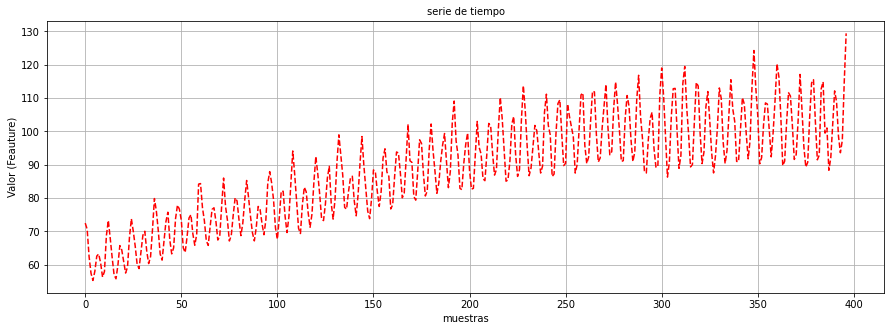

In [ ]:
dataset = datos2.values
dataset = dataset.astype('float32')

senal = dataset
print(senal.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(senal, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

(397, 1)


Text(0.5, 1.0, 'serie de tiempo')

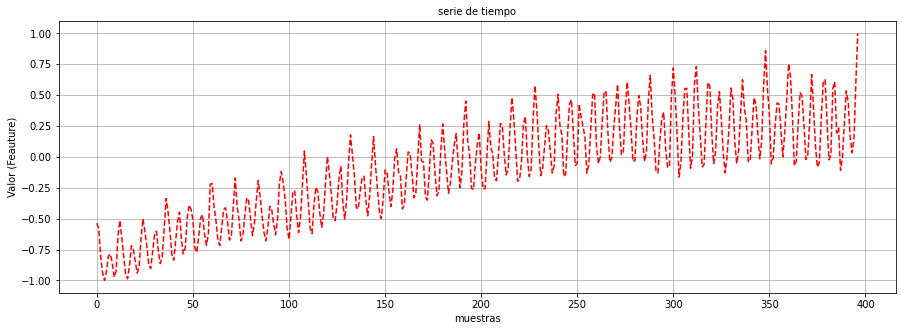

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1)) 
senal2 = scaler.fit_transform(senal.reshape(-1,1))
print(senal2.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(senal2, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

Con la data normalizada entre margenes mas manejables, se separa la informacion de entrada entre entrenamiento y test. El ratio de separacion escogido fue de un 80%, ya que mayor porcentaje perjudica el entrenamiento y posterior validacion del modelo.

In [ ]:
# generar conjuntos
porcentaje = 0.8
train_size = int(len(senal2) * porcentaje)
test_size = len(senal2) - train_size
train, test = senal2[0:train_size,:], senal2[train_size:len(senal2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

317 80
(317, 1)
(80, 1)


In [ ]:
# val
train_size1 = int(len(train) * porcentaje)
val_size = len(train) - train_size1
train, val = train[0:train_size1,:], train[train_size1:len(senal2),:]

print("los conjuntos quedan: train:", len(train), ", val: ", len(val),  ", test: ", len(test))
print(train.shape)
print(val.shape)
print(test.shape)

los conjuntos quedan: train: 253 , val:  64 , test:  80
(253, 1)
(64, 1)
(80, 1)


Con los datos separados, se propone el modelo de LSTM con funcion de activacion ReLu, que prediga 2 valores y con una ventada de datos de 5 valores al futuro.

In [ ]:
n_steps_in = 5 #5  # ventana de n datos de entrada 
n_steps_out = 2#3  # n predicciones 
n_features = 1 #1   # solo un feature (no cambiar en este ejemplo)

In [ ]:
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)   # generamos la división
valX, valY = split_sequence(val, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

In [ ]:
trainY = np.reshape(trainY, (trainY.shape[0],trainY.shape[1]))
valY = np.reshape(valY, (valY.shape[0],valY.shape[1]))
testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))

In [ ]:
# network
output_dim= 100

def modelo_lstm():
    model = Sequential()
    model.add(LSTM(output_dim, activation='relu', input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dense(16, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mae', optimizer='rmsprop', metrics=['mse', 'mae'])
    return model

In [ ]:
batch_size= 8
epochs= 15

model = modelo_lstm()
model.summary()
start = time.time()

history = model.fit(trainX, trainY, batch_size=batch_size, epochs= epochs, validation_data=(valX,valY))

print("> tiempro entrenando... : ", time.time() - start)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
31/31 [==============================] - 1s 12ms/step - loss: 0.2874 - mse: 0.1228 - mae: 0.2874 - val_loss: 0.2967 - val_mse: 0.1419 - val_mae: 0.2967
Epoch 2/15
31/31 [==============================] - 0s 4ms/step - loss: 0.1826 - mse: 0.0504 - mae: 0.1826 - val_loss: 0.2697 - val_mse: 0.1160 - val_mae: 0.2697
Epoch 3/15
31/31 [==============================] - 0s 5ms/step - loss: 0.1770 - mse: 0.0458 - mae: 0.1770 - val_loss: 0.2482 - val_mse: 0.0965 - val_mae: 0.2482
Epoch 4/15
31/31 [======

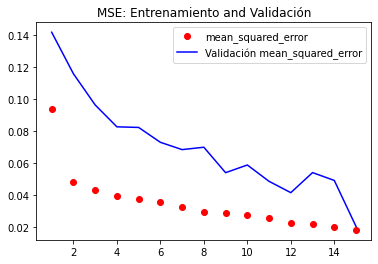

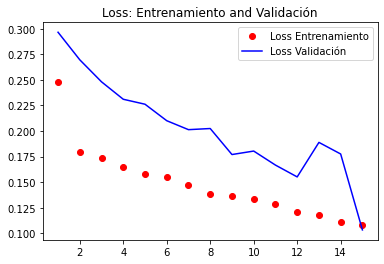

In [ ]:
mae = history.history['mse']
val_mae = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mean_squared_error')
plt.plot(epochs, val_mae , 'b', label='Validación mean_squared_error')
plt.title('MSE: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")

# gráfico para la pérdida obtenido de los datos de la historia 
plt.figure()
plt.plot(epochs, loss, 'ro', label='Loss Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss Validación')
plt.title('Loss: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig2.png")
plt.show()

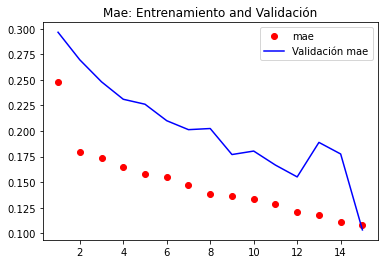

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mae')
plt.plot(epochs, val_mae , 'b', label='Validación mae')
plt.title('Mae: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")

In [ ]:
# predicciones de los valores de entrenamiento y prueba 
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# desnormalizar
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.8f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Val Score: %.8f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 4.85469089 RMSE
Val Score: 5.30243420 RMSE
Test Score: 6.38177101 RMSE


In [ ]:
print('MAE del entrenamiento promedio: %.8f MAE' % (np.mean(mae)))

trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.8f MAE' % (trainScore))

valScore = mean_absolute_error(valY, valPredict)
print('Val Score: %.8f MAE' % (valScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.8f MAE' % (testScore))

MAE del entrenamiento promedio: 0.14794679 MAE
Train Score: 3.86204982 MAE
Val Score: 3.82397938 MAE
Test Score: 4.78404665 MAE


In [ ]:
score = model.evaluate(testX , testPredict)
print(score)

3/3 [==============================] - 0s 3ms/step - loss: 99.2586 - mse: 9891.4375 - mae: 99.2586
[99.25860595703125, 9891.4375, 99.25860595703125]


Text(0.5, 1.0, 'Gráfico de predicciones vs datos reales')

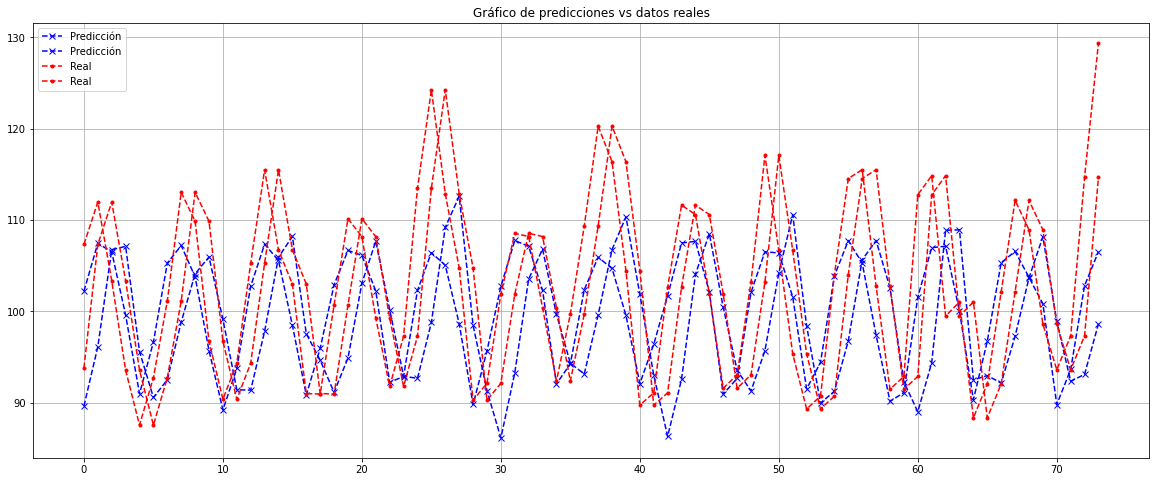

In [ ]:
plt.figure(figsize=[20,8])
plt.plot(testPredict ,'b--x', label="Predicción")
plt.plot(testY, 'r--.', label="Real")
plt.grid()
plt.legend(loc='upper left')
plt.title("Gráfico de predicciones vs datos reales", fontsize = 12)